<a href="https://colab.research.google.com/github/livinNector/deep-learning-tools-lab/blob/main/7%20-%20Sentence%20Classification%20Using%20RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 7 - Document Classification Using RNN

References:
- [RNN with keras](https://www.tensorflow.org/guide/keras/rnn)
- [Text Classification using RNN](https://www.tensorflow.org/text/tutorials/text_classification_rnn)

## Dataset

- Dataset Used : Imdb Movie Review dataset
- Dataset Url : https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
- Dataset Home Page: https://ai.stanford.edu/~amaas/data/sentiment

## Importing the required modules

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import re
import shutil
import string

## Dataset

### Downloading the dataset 

- Dataset: Imdb Large Movie Review Dataset v1.0 
- Home Page : https://ai.stanford.edu/~amaas/data/sentiment/
- Dataset URL : https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz

In [2]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file(
    "aclImdb_v1", url,
    untar=True, cache_dir='.',
    cache_subdir=''
)

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')


### Exploring the dataset directory

In [3]:
os.listdir(dataset_dir)

['test', 'README', 'imdbEr.txt', 'train', 'imdb.vocab']

In [4]:
train_dir = os.path.join(dataset_dir,"train")
os.listdir(train_dir)

['neg',
 'unsupBow.feat',
 'urls_neg.txt',
 'unsup',
 'urls_unsup.txt',
 'urls_pos.txt',
 'pos',
 'labeledBow.feat']

Here `pos` and `neg` are the folders containing positive and negative reviews.



### Removing unwanted folders from training folder

`unsup` contains data for unsupervised learning which is not needed for this exercise. so we remove that using `shutil.rmtree()`

In [5]:
shutil.rmtree(os.path.join(train_dir,"unsup"))

### Loading the dataset

In [6]:
batch_size = 128
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='training', 
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


In [7]:
raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='validation', 
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [8]:
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/test', 
    batch_size=batch_size)

Found 25000 files belonging to 2 classes.


In [9]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = raw_val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = raw_test_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Preprocessing the text

### Standardization Function

In [10]:
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
    return tf.strings.regex_replace(
        stripped_html,
        f'[{re.escape(string.punctuation)}]',
        ''
    )

### Text Vectorization

- Create a `TextVectorization` layer with the `custom_standardization` function
- Adapt it with the training data
- Create a function that applies vectorization only to the text in the dataset so that it can be mapped to the dataset


In [16]:
max_features = 10000
sequence_length = 250

vectorize_layer = tf.keras.layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)
vectorize_layer.adapt(raw_train_ds.map(lambda x, y: x))

## Creating the Model

In [17]:
model = tf.keras.Sequential([
    vectorize_layer,
    tf.keras.layers.Embedding(
        input_dim=len(vectorize_layer.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])


In [18]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [19]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (TextV  (None, 250)              0         
 ectorization)                                                   
                                                                 
 embedding_1 (Embedding)     (None, 250, 64)           640000    
                                                                 
 bidirectional_2 (Bidirectio  (None, 250, 128)         66048     
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                      

In [20]:
history = model.fit(train_ds, epochs=10,
                    validation_data=val_ds,
                    validation_steps=30)


Epoch 1/10
157/157 [==============================] - 214s 1s/step - loss: 0.6844 - accuracy: 0.5127 - val_loss: 0.5949 - val_accuracy: 0.6773
Epoch 2/10
157/157 [==============================] - 194s 1s/step - loss: 0.4138 - accuracy: 0.8120 - val_loss: 0.3435 - val_accuracy: 0.8557
Epoch 3/10
157/157 [==============================] - 194s 1s/step - loss: 0.2697 - accuracy: 0.8926 - val_loss: 0.3085 - val_accuracy: 0.8669
Epoch 4/10
157/157 [==============================] - 194s 1s/step - loss: 0.2107 - accuracy: 0.9236 - val_loss: 0.3206 - val_accuracy: 0.8693
Epoch 5/10
157/157 [==============================] - 193s 1s/step - loss: 0.1814 - accuracy: 0.9370 - val_loss: 0.3400 - val_accuracy: 0.8727
Epoch 6/10
157/157 [==============================] - 193s 1s/step - loss: 0.1681 - accuracy: 0.9396 - val_loss: 0.4017 - val_accuracy: 0.8573
Epoch 7/10
157/157 [==============================] - 192s 1s/step - loss: 0.1521 - accuracy: 0.9481 - val_loss: 0.4422 - val_accuracy: 0.8513

In [21]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

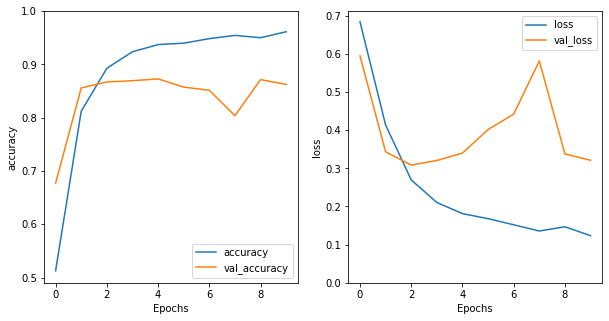

In [22]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)
plt.show()


## Evaluating the model

In [23]:
test_loss, test_acc = model.evaluate(test_ds)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)


196/196 [==============================] - 69s 349ms/step - loss: 0.3627 - accuracy: 0.8426
Test Loss: 0.36270952224731445
Test Accuracy: 0.8426399827003479


## Sample Predictions

In [24]:
import numpy as np

In [25]:
samples = np.array([
  'The movie was awesome, wonderful and amazing.',
  "The Movies is the bad and waste of time."              
])
predictions = model.predict(samples)

In [26]:
predictions

array([[ 1.3299981],
       [-1.356227 ]], dtype=float32)